In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint, uniform 
import random
from sklearn.model_selection import KFold, cross_val_score
import re
import tldextract
from urllib.parse import urlparse
from collections import Counter
from scipy.stats import entropy

import warnings
warnings.filterwarnings("ignore") 

In [2]:
X = pd.read_csv('/Users/tanishagangrade/Downloads/phishing_site_urls.csv')

#Removing Unnecessary spaces
X['URL'].str.strip()

print(X)

                                                      URL Label
0       nobell.it/70ffb52d079109dca5664cce6f317373782/...   bad
1       www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...   bad
2       serviciosbys.com/paypal.cgi.bin.get-into.herf....   bad
3       mail.printakid.com/www.online.americanexpress....   bad
4       thewhiskeydregs.com/wp-content/themes/widescre...   bad
...                                                   ...   ...
549341                                    23.227.196.215/   bad
549342                                 apple-checker.org/   bad
549343                                  apple-iclods.org/   bad
549344                                 apple-uptoday.org/   bad
549345                                  apple-search.info   bad

[549346 rows x 2 columns]


### Special character in bad urls

In [3]:
special_df = pd.DataFrame()

special_chars = set() 

def find_special_char(x):
    special_chars_in_x = re.findall(r'[^a-zA-Z0-9]', x)
    special_chars.update(special_chars_in_x)
    return None

X_bad = X[X['Label'] == 'bad']
X_bad['URL'].apply(find_special_char)

special_chars = list(special_chars)

special_chars.remove('.')
special_chars.remove('/')

special_df['Special Character'] = special_chars
special_df['Frequency in bad URLs'] = special_df['Special Character'].apply(lambda x: X_bad[X_bad['URL'].str.contains(re.escape(x), regex=True)].shape[0])
special_df['Bad probability'] = special_df['Frequency in bad URLs']/special_df['Special Character'].apply(lambda x: X[X['URL'].str.contains(re.escape(x), regex=True)].shape[0])
special_df['Score'] = special_df['Bad probability']*special_df['Frequency in bad URLs'].apply(math.log)

special_df.sort_values(by='Score', ignore_index=True, ascending=False, inplace=True)
special_df


,Special Character,Frequency in bad URLs,Bad probability,Score
0,\,6363,0.966874,8.468132
1,;,11294,0.906639,8.460778
2,,1066,0.955197,6.659318
3,@,1809,0.882870,6.621990
4,',3591,0.774089,6.336839
...,...,...,...,...
167,,1,0.043478,0.000000
168,¦,1,0.037037,0.000000
169,Á,1,0.045455,0.000000
170,È,1,0.040000,0.000000


['\\', ';', ' ', '@', "'", ':', '&', '>', '<', '=']


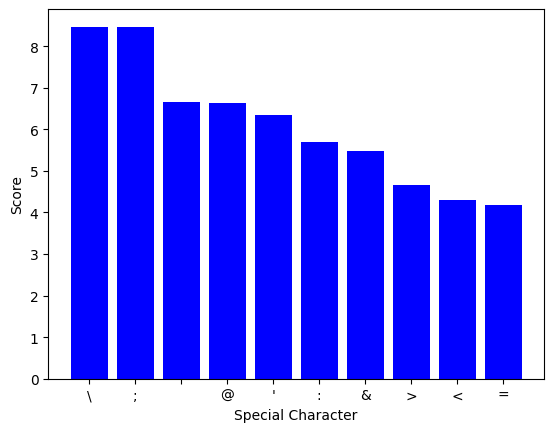

In [4]:
# only top ten are special characters

dangerous_chars = list(special_df['Special Character'].head(10))
print(dangerous_chars)
# colors = ['red', 'blue', 'green', 'purple', 'orange', 'pink', 'cyan', 'brown', 'yellow', 'magenta']
plt.bar(special_df['Special Character'].head(10), special_df['Score'].head(10), color = 'blue')
plt.xlabel('Special Character')
plt.ylabel('Score')
plt.show() 

#### To identify TLDs (Top Level Domain) in bad urls

In [5]:
TLD_df = pd.DataFrame()

TLD_list = pd.Series(X_bad['URL'].apply(lambda x: tldextract.extract(x).suffix)).unique()

TLD_df['TLD'] = TLD_list

TLD_df['Frequency in bad URLs'] = TLD_df['TLD'].apply(lambda x: X_bad[X_bad['URL'].str.contains(re.escape(x), regex=True)].shape[0])
TLD_df['Bad probability'] = TLD_df['Frequency in bad URLs']/TLD_df['TLD'].apply(lambda x: X[X['URL'].str.contains(re.escape(x), regex=True)].shape[0])
TLD_df['Score'] = TLD_df['Bad probability']*TLD_df['Frequency in bad URLs'].apply(math.log)

TLD_df.sort_values(by='Score', ignore_index=True, ascending=False, inplace=True)
TLD_df



,TLD,Frequency in bad URLs,Bad probability,Score
0,com.br,4235,0.982599,8.205817
1,mx,3698,0.931486,7.652669
2,cm,10508,0.812495,7.523618
3,bf,3900,0.878576,7.264711
4,date,5402,0.775258,6.662977
...,...,...,...,...
601,com.bb,1,1.000000,0.000000
602,sa.edu.au,1,0.142857,0.000000
603,gob.do,1,1.000000,0.000000
604,edu.bt,1,1.000000,0.000000


['com.br', 'mx', 'cm', 'bf', 'date', 'run', 'xyz', 'mg', 'com.ar', 'ph']


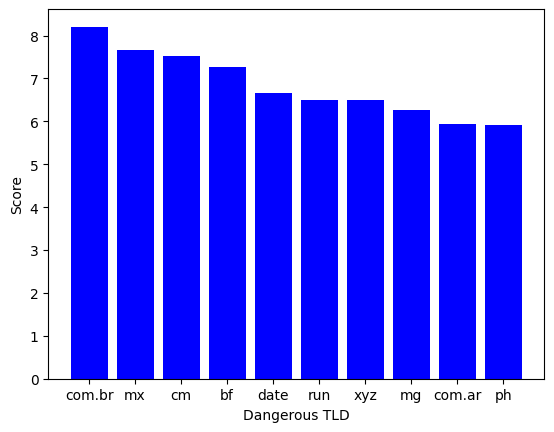

In [6]:
dangerous_TLDs = list(TLD_df['TLD'].head(10))
print(dangerous_TLDs)
plt.bar(TLD_df['TLD'].head(10), TLD_df['Score'].head(10), color = 'blue')
plt.xlabel('Dangerous TLD')
plt.ylabel('Score')
plt.show()

## Feature Extraction

In [7]:
#1 URL length

X['URL length'] = X['URL'].apply(len)

#2 Numbers of dots

X['Number of dots'] = X['URL'].apply(lambda x: x.count('.'))

#3 Number of slashes

X['Number of slashes'] = X['URL'].apply(lambda x: x.count('/'))

#4 Percentage of numerical characters

X['Percentage of numerical characters'] = X['URL'].apply(lambda x: sum(c.isdigit() for c in x))/X['URL length']

#5 Dangerous characters

X['Dangerous characters'] = X['URL'].apply(lambda x: any(char in x for char in dangerous_chars))

#6 Dangerous TLD

X['Dangerous TLD'] = X['URL'].apply(lambda x: tldextract.extract(x).suffix in dangerous_TLDs)

#7 Entropy

def urlentropy(url):
    frequencies = Counter(url)
    prob = [frequencies[char] / len(url) for char in url]
    return entropy(prob, base=2)


X['Entropy'] = X['URL'].apply(urlentropy)

#8 IP Address

ip_pattern = r'[0-9]+(?:\.[0-9]+){3}'
X['IP Address'] = X['URL'].apply(lambda x: bool(re.search(ip_pattern, x)))

#9 Domain name length

X['Domain name length'] = X['URL'].apply(lambda x: len(tldextract.extract(x).domain))

#10 Suspicious keywords

sus_words = ['secure', 'account', 'update', 'login', 'verify' ,'signin', 'bank',
            'notify', 'click', 'inconvenient']

X['Suspicious keywords'] = X['URL'].apply(lambda x: sum([word in x for word in sus_words]) != 0)


#11 Repetitions

X['Repetitions'] = X['URL'].apply(lambda x: True if re.search(r'(.)\1{2,}', tldextract.extract(x).domain) else False)

#12 Redirections

def redirection(url):
  pos = url.rfind('//') #If the // is not found, it returns -1
  return pos>7

X['Redirections'] = X['URL'].apply(redirection)

In [8]:
# printing the new dataset
X 

,URL,Label,URL length,Number of dots,Number of slashes,Percentage of numerical characters,Dangerous characters,Dangerous TLD,Entropy,IP Address,Domain name length,Suspicious keywords,Repetitions,Redirections
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,225,6,10,0.257778,True,False,7.667575,False,6,True,False,False
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,81,5,4,0.012346,True,False,6.190289,False,7,False,False,False
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,177,7,11,0.265537,False,False,7.288285,False,12,True,False,False
3,mail.printakid.com/www.online.americanexpress....,bad,60,6,2,0.000000,False,False,5.786667,False,9,False,False,False
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,116,1,10,0.181034,False,False,6.611978,False,15,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549341,23.227.196.215/,bad,15,3,1,0.733333,False,False,3.693150,True,14,False,False,False
549342,apple-checker.org/,bad,18,1,1,0.000000,False,False,4.031402,False,13,False,False,False
549343,apple-iclods.org/,bad,17,1,1,0.000000,False,False,4.001823,False,12,False,False,False
549344,apple-uptoday.org/,bad,18,1,1,0.000000,False,False,4.012188,False,13,False,False,False


## EDA and Feature Engineering

In [9]:
# Standardizing numerical features

scaler = StandardScaler()

num_columns = ['URL length', 'Number of dots', 'Number of slashes', 'Domain name length', 'Entropy']

X[num_columns] = scaler.fit_transform(X[num_columns]) 

In [10]:
X['IP Address'] = X['IP Address'].astype(int)
X['Suspicious keywords'] = X['Suspicious keywords'].astype(int)
X['Repetitions'] = X['Repetitions'].astype(int)
X['Redirections'] = X['Redirections'].astype(int)
X['Dangerous characters'] = X['Dangerous characters'].astype(int)
X['Dangerous TLD'] = X['Dangerous TLD'].astype(int)
X['Label'] = (X['Label'] == 'good').astype(int)

X.drop(columns=['URL'], inplace=True)

In [11]:
X

,Label,URL length,Number of dots,Number of slashes,Percentage of numerical characters,Dangerous characters,Dangerous TLD,Entropy,IP Address,Domain name length,Suspicious keywords,Repetitions,Redirections
0,0,3.923264,2.599770,4.734477,0.257778,1,0,3.043151,0,-0.799144,1,0,0
1,0,0.681338,1.939541,0.974386,0.012346,1,0,1.213456,0,-0.582606,0,0,0
2,0,2.842622,3.259998,5.361159,0.265537,0,0,2.573382,0,0.500081,1,0,0
3,0,0.208557,2.599770,-0.278978,0.000000,0,0,0.713550,0,-0.149531,0,0,0
4,0,1.469306,-0.701371,4.734477,0.181034,0,0,1.735740,0,1.149694,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
549341,0,-0.804544,0.619085,-0.905660,0.733333,0,0,-1.879379,1,0.933156,0,0,0
549342,0,-0.737004,-0.701371,-0.905660,0.000000,0,0,-1.460437,0,0.716619,0,0,0
549343,0,-0.759518,-0.701371,-0.905660,0.000000,0,0,-1.497072,0,0.500081,0,0,0
549344,0,-0.737004,-0.701371,-0.905660,0.000000,0,0,-1.484234,0,0.716619,0,0,0


## Heat Map of the Correlation Matrix

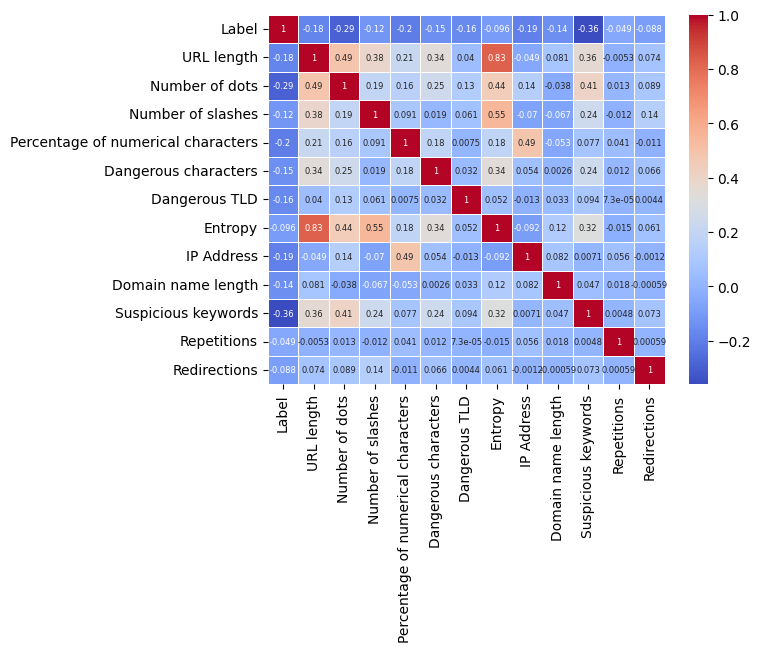

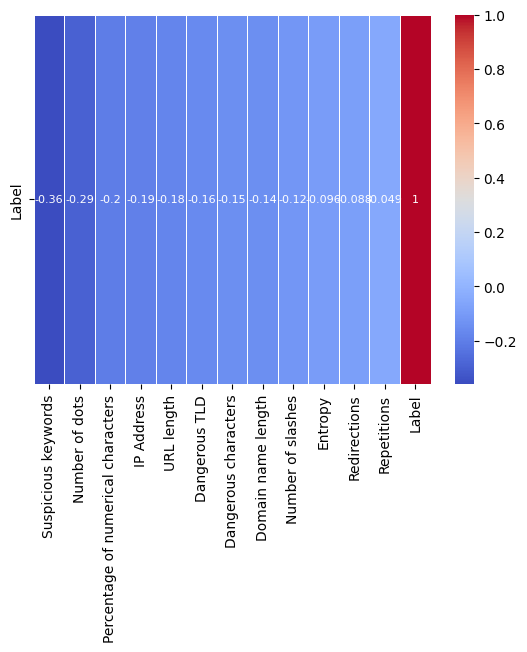

                                       Label
Suspicious keywords                -0.360325
Number of dots                     -0.293474
Percentage of numerical characters -0.204039
IP Address                         -0.191832
URL length                         -0.177295
Dangerous TLD                      -0.163621
Dangerous characters               -0.146440
Domain name length                 -0.144381
Number of slashes                  -0.118405
Entropy                            -0.096089
Redirections                       -0.088167
Repetitions                        -0.049215
Label                               1.000000


In [12]:
corr_matrix = X.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, annot_kws={"size": 6})
plt.show()
sns.heatmap(corr_matrix[['Label']].sort_values(by='Label').T, annot=True, cmap='coolwarm', linewidths=0.5, annot_kws={"size": 8})
plt.show()
print(corr_matrix[['Label']].sort_values(by='Label')) 

## Applying PCA (Principle Component Analysis)

In [13]:
pca = PCA(n_components=1)
X['Entropy and length (PCA)'] = pca.fit_transform(X[['Entropy', 'URL length']])
X.drop(columns=['Entropy', 'URL length'], inplace=True)

# Since entropy and url_length are highly correlated, therefore we apply PCA.

In [14]:
X

,Label,Number of dots,Number of slashes,Percentage of numerical characters,Dangerous characters,Dangerous TLD,IP Address,Domain name length,Suspicious keywords,Repetitions,Redirections,Entropy and length (PCA)
0,0,2.599770,4.734477,0.257778,1,0,0,-0.799144,1,0,0,4.926000
1,0,1.939541,0.974386,0.012346,1,0,0,-0.582606,0,0,0,1.339822
2,0,3.259998,5.361159,0.265537,0,0,0,0.500081,1,0,0,3.829693
3,0,2.599770,-0.278978,0.000000,0,0,0,-0.149531,0,0,0,0.652028
4,0,-0.701371,4.734477,0.181034,0,0,0,1.149694,0,0,1,2.266310
...,...,...,...,...,...,...,...,...,...,...,...,...
549341,0,0.619085,-0.905660,0.733333,0,0,1,0.933156,0,0,0,-1.897821
549342,0,-0.701371,-0.905660,0.000000,0,0,0,0.716619,0,0,0,-1.553825
549343,0,-0.701371,-0.905660,0.000000,0,0,0,0.500081,0,0,0,-1.595650
549344,0,-0.701371,-0.905660,0.000000,0,0,0,0.716619,0,0,0,-1.570652


## Train Test Split Model

##### Since we are working with binary classification model, so we need this model to so that both the classes i.e. good and bad are equally represented

In [15]:
X['Label'].value_counts(normalize=True)

Label
1    0.715258
0    0.284742
Name: proportion, dtype: float64

In [16]:
n_samples = X['Label'].value_counts()[0]
X_good = X[X['Label'] == 1]
X_bad = X[X['Label'] == 0]
X_goodsample = X_good.sample(n=n_samples, random_state=22)
X_goodmissing = X_good.drop(X_goodsample.index)

X = pd.concat([X_bad, X_goodsample], ignore_index=True)

In [17]:
X

,Label,Number of dots,Number of slashes,Percentage of numerical characters,Dangerous characters,Dangerous TLD,IP Address,Domain name length,Suspicious keywords,Repetitions,Redirections,Entropy and length (PCA)
0,0,2.599770,4.734477,0.257778,1,0,0,-0.799144,1,0,0,4.926000
1,0,1.939541,0.974386,0.012346,1,0,0,-0.582606,0,0,0,1.339822
2,0,3.259998,5.361159,0.265537,0,0,0,0.500081,1,0,0,3.829693
3,0,2.599770,-0.278978,0.000000,0,0,0,-0.149531,0,0,0,0.652028
4,0,-0.701371,4.734477,0.181034,0,0,0,1.149694,0,0,1,2.266310
...,...,...,...,...,...,...,...,...,...,...,...,...
312839,1,-0.701371,-0.905660,0.000000,0,0,0,-0.582606,0,0,0,-0.692077
312840,1,-0.041143,-0.278978,0.000000,0,0,0,-0.149531,0,0,0,-0.964574
312841,1,-0.041143,0.347704,0.000000,0,0,0,-1.448756,0,0,0,-0.415293
312842,1,-0.041143,-0.905660,0.000000,0,0,0,-0.366069,0,0,0,-0.232647


##### Dividing feature from target

In [18]:
y = X['Label']
X.drop(columns=['Label'], inplace=True)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

y_goodmissing = X_goodmissing['Label']
X_goodmissing.drop(columns=['Label'], inplace=True)

# Merging X_test and X_goodmissing

X_test = pd.concat([X_test, X_goodmissing], axis=0)

# Merging y_test and y_goodmissing

y_test = pd.concat([y_test, y_goodmissing], axis=0)

## Constructing ML Model

In [20]:
kf = KFold(n_splits=3, shuffle=True, random_state=22)

xgb_model = XGBClassifier(random_state=22)
print(cross_val_score(xgb_model, X_train, y_train, cv=kf, scoring='accuracy').mean())

rf_model = RandomForestClassifier(random_state=22)
print(cross_val_score(rf_model, X_train, y_train, cv=kf, scoring='accuracy').mean()) 

0.8395924483068624
0.8601218659474578


In [21]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Define default Scikit-Learn tags
DEFAULT_SKLEARN_TAGS = {
    "non_deterministic": False,
    "requires_positive_X": False,
    "requires_positive_y": False,
    "multioutput": False,
    "poor_score": False,
    "no_validation": False,
    "stateless": False
}

# Correct fix: Define missing __sklearn_tags__ method
def patch_estimator(estimator):
    if not hasattr(estimator, "__sklearn_tags__"):
        estimator.__sklearn_tags__ = lambda: DEFAULT_SKLEARN_TAGS.copy()

# Initialize models
xgb_model = XGBClassifier(random_state=22)
rf_model = RandomForestClassifier(random_state=22)

# Apply patch
patch_estimator(xgb_model)
patch_estimator(rf_model)


In [22]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Define a universal fix by overriding __sklearn_tags__
def patch_sklearn_tags(estimator):
    if not hasattr(estimator, "__sklearn_tags__"):
        def _sklearn_tags():
            return {"estimator_type": "classifier"}  # Minimal required tag
        estimator.__sklearn_tags__ = _sklearn_tags

# Initialize models
xgb_model = XGBClassifier(random_state=22)
rf_model = RandomForestClassifier(random_state=22)

# Apply patch
patch_sklearn_tags(xgb_model)
patch_sklearn_tags(rf_model)

print("Patch applied successfully!")


Patch applied successfully!


In [23]:
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Define models
xgb_model = XGBClassifier(random_state=22)
rf_model = RandomForestClassifier(random_state=22)

# Define cross-validation strategy
kf = KFold(n_splits=3, shuffle=True, random_state=22)

# Run cross-validation
xgb_score = cross_val_score(xgb_model, X_train, y_train, cv=kf, scoring='accuracy').mean()
rf_score = cross_val_score(rf_model, X_train, y_train, cv=kf, scoring='accuracy').mean()

# Print results
print(f"XGBoost Accuracy: {xgb_score:.4f}")
print(f"Random Forest Accuracy: {rf_score:.4f}")

XGBoost Accuracy: 0.8396
Random Forest Accuracy: 0.8601


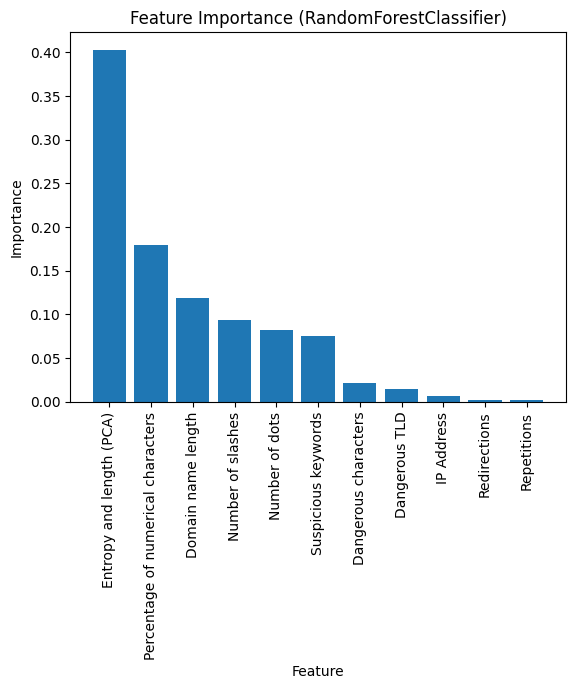

In [24]:
rf_model.fit(X_train, y_train)
importances = rf_model.feature_importances_
feature_names = X.columns 
indices = np.argsort(importances)[::-1]

plt.title('Feature Importance (RandomForestClassifier)')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show() 

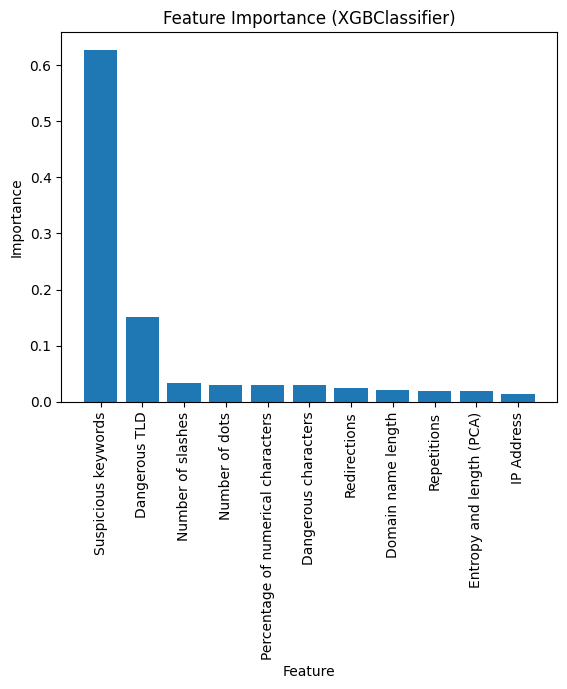

In [25]:
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feature_names = X.columns 
indices = np.argsort(importances)[::-1]

plt.title('Feature Importance (XGBClassifier)')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

In [28]:
from sklearn.metrics import accuracy_score

rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)

print(accuracy_score(y_test, rf_pred))
print(accuracy_score(y_test, xgb_pred)) 

0.8640924730248001
0.8631896773675816


## Hyperparameter Tuning

In [26]:
import optuna



def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 400)
    max_depth = trial.suggest_int('max_depth', 3, 7)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 0.3)
    subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-3, 10.0)

    
    model = XGBClassifier(
        random_state=22,
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        reg_alpha=reg_alpha,
        use_label_encoder=False,
        eval_metric='mlogloss'
    )

    
    mean_score = cross_val_score(model, X, y, cv=kf, scoring='accuracy').mean()
    return mean_score 


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50) 


print("Best hyperparameters:", study.best_params)
print("Best accuracy:", study.best_value)

best_xgb_model =XGBClassifier(random_state=22, **study.best_params)

[I 2025-02-24 20:34:05,373] A new study created in memory with name: no-name-a57fa838-dd85-4e38-9fb5-833614969287
[I 2025-02-24 20:34:08,250] Trial 0 finished with value: 0.7654677701790648 and parameters: {'n_estimators': 344, 'max_depth': 4, 'learning_rate': 0.009947560949273042, 'subsample': 0.71042185725013, 'reg_alpha': 2.743404495613502}. Best is trial 0 with value: 0.7654677701790648.
[I 2025-02-24 20:34:11,341] Trial 1 finished with value: 0.8453829991182212 and parameters: {'n_estimators': 283, 'max_depth': 6, 'learning_rate': 0.1685221488695208, 'subsample': 0.8297429453024372, 'reg_alpha': 5.778550933082528}. Best is trial 1 with value: 0.8453829991182212.
[I 2025-02-24 20:34:13,386] Trial 2 finished with value: 0.823151469366088 and parameters: {'n_estimators': 205, 'max_depth': 5, 'learning_rate': 0.059831044990469345, 'subsample': 0.6603975276280828, 'reg_alpha': 0.25250636762734063}. Best is trial 1 with value: 0.8453829991182212.
[I 2025-02-24 20:34:15,639] Trial 3 fini

Best hyperparameters: {'n_estimators': 399, 'max_depth': 7, 'learning_rate': 0.14211410095609167, 'subsample': 0.9083597215295495, 'reg_alpha': 0.6266339310847686}
Best accuracy: 0.8525431157787852


In [29]:
best_xgb_model.fit(X_train, y_train)

best_xgb_pred = best_xgb_model.predict(X_test)

print(accuracy_score(y_test, best_xgb_pred)) 

0.8720002942445105


In [30]:
import numpy as np
import re
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Sample dataset (Ensure X and y are preprocessed correctly)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)  

RandomForestClassifier(random_state=42)

In [31]:
def extract_features(url):
    """Extracts numerical features from a URL for phishing detection."""
    parsed_url = urlparse(url)
    domain = parsed_url.netloc
    path = parsed_url.path
    
    # Feature 1: URL Length
    url_length = len(url)
    
    # Feature 2: Number of dots in domain
    num_dots = domain.count(".")
    
    # Feature 3: Number of slashes in path
    num_slashes = path.count("/")
    
    # Feature 4: Domain length
    domain_length = len(domain)
    
    # Feature 5: Entropy of the URL (measures randomness)
    def calculate_entropy(string):
        from collections import Counter
        import math
        counter = Counter(string)
        length = len(string)
        entropy = -sum((freq / length) * math.log2(freq / length) for freq in counter.values())
        return entropy

    entropy = calculate_entropy(url)

    # Feature 6: Presence of suspicious keywords
    suspicious_keywords = ['login', 'bank', 'secure', 'update', 'verify']
    contains_suspicious = int(any(keyword in url.lower() for keyword in suspicious_keywords))

    # Feature 7: Presence of IP address in URL
    def contains_ip_address(url):
        """Check if a URL contains an IP address instead of a domain"""
        ip_pattern = r'(\d{1,3}\.){3}\d{1,3}'
        return int(bool(re.search(ip_pattern, url)))
    
    has_ip = contains_ip_address(url)

    # ADDITIONAL FEATURES to match the trained model
    # Feature 8: Number of hyphens in domain
    num_hyphens = domain.count('-')

    # Feature 9: Number of query parameters (URL parameters after "?")
    num_params = len(parsed_url.query.split('&')) if parsed_url.query else 0

    # Feature 10: Uses HTTPS (1 if HTTPS, 0 if HTTP)
    uses_https = 1 if url.startswith("https") else 0

    # Feature 11: Length of the path after domain
    path_length = len(path)

    # Ensure the feature count matches the training data (11 features)
    return np.array([url_length, num_dots, num_slashes, domain_length, entropy, contains_suspicious, has_ip,
                     num_hyphens, num_params, uses_https, path_length]) 

In [32]:
test_urls = [
    "https://secure-bank-login.com",
    "http://update-account-verification.com",
    "https://google.com",
    "http://192.168.1.1/login",
    "https://www.amazon.com",
]

for url in test_urls:
    features = np.array(extract_features(url)).reshape(1, -1)
    print(f"Extracted {features.shape[1]} features")  # Ensure correct feature count
    prediction = model.predict(features)[0]
    print(f"URL: {url} → {'Phishing' if prediction == 1 else 'Legitimate'}") 

Extracted 11 features
URL: https://secure-bank-login.com → Legitimate
Extracted 11 features
URL: http://update-account-verification.com → Legitimate
Extracted 11 features
URL: https://google.com → Legitimate
Extracted 11 features
URL: http://192.168.1.1/login → Legitimate
Extracted 11 features
URL: https://www.amazon.com → Legitimate


# Deploying the model on Flask API

In [33]:
import joblib

# Assuming `model` is your trained model
joblib.dump(model, "phishing_model.pkl")


['phishing_model.pkl']

In [34]:
import joblib

# Train the model (if not trained already)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd

# Load dataset
df = pd.read_csv('/Users/tanishagangrade/Downloads/phishing_site_urls.csv')
df['features'] = df['URL'].apply(lambda x: extract_features(x))
X = np.array(df['features'].tolist())
y = np.array(df['Label'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Save model
joblib.dump(model, "phishing_model.pkl")
print("Model saved successfully!")


Model saved successfully!


In [35]:
from flask import Flask, request, jsonify
import pickle  # or joblib if you used it

# Initialize the Flask application
app = Flask(__name__)


In [36]:
# Load the saved model (adjust the filename and method as needed)
with open('phishing_model.pkl', 'rb') as file:
    model = pickle.load(file)


In [37]:
@app.route('/predict', methods=['POST'])
def predict():
    # Parse the JSON request
    data = request.get_json(force=True)
    
    # Example: extract input features from the JSON. Adjust this based on your input format.
    # For example, if your model expects a list of features:
    features = data.get('features')
    
    # Ensure features are provided
    if features is None:
        return jsonify({'error': 'No features provided'}), 400

    # Use the model to make a prediction. Wrap in a list if your model expects a 2D array.
    prediction = model.predict([features])
    
    # Convert prediction to a list (if it's an array) or format as needed
    output = prediction.tolist() if hasattr(prediction, 'tolist') else prediction

    return jsonify({'prediction': output})


In [ ]:
if __name__ == '__main__':
    app.run(port=5020, debug=True) 